#  Lab 03: Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

**Name:** Jay Sindhal  
**Student ID:** 8963474

##  Question 1: Obtain the Data

The dataset used for this lab is the Dogs vs Cats dataset. We were supposed to use only 5000 images (2500 cats and 2500 dogs). Since the full dataset has 25,000 images, I manually selected and organized a smaller version beforehand.

The structure of the dataset now looks like this:



In [16]:
from pathlib import Path
import os

# path to where the dataset is stored
base_path = Path("C:/Users/Dell/Downloads/Lab 03/catsanddogs/dataset")
train_dir = base_path / "train"
valid_dir = base_path / "valid"

print("Train folders:", os.listdir(train_dir))
print("Valid folders:", os.listdir(valid_dir))


Train folders: ['cats', 'dogs']
Valid folders: ['cats', 'dogs']


##  Question 2: EDA (Explore the Data)

Before training the model, I wanted to look into the data a bit. Mainly just to check if both classes (dogs and cats) are balanced in the training and validation sets.

Also I wanted to visualize a few sample images to make sure things look normal.


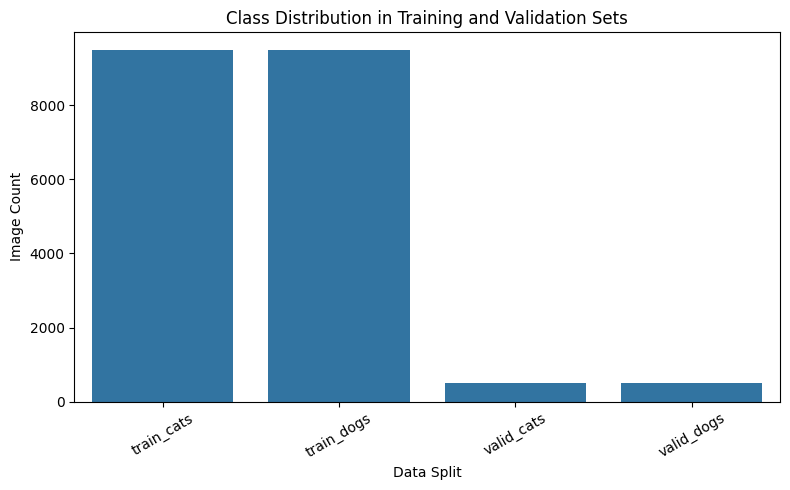

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_folder = directory / class_name
        if class_folder.is_dir():
            count = len(list(class_folder.glob("*.jpg")))
            class_counts[class_name] = count
    return class_counts

train_counts = count_images(train_dir)
valid_counts = count_images(valid_dir)

# combining the count data
all_counts = {
    "train_cats": train_counts.get("cats", 0),
    "train_dogs": train_counts.get("dogs", 0),
    "valid_cats": valid_counts.get("cats", 0),
    "valid_dogs": valid_counts.get("dogs", 0),
}

# plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(all_counts.keys()), y=list(all_counts.values()))
plt.title("Class Distribution in Training and Validation Sets")
plt.ylabel("Image Count")
plt.xlabel("Data Split")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


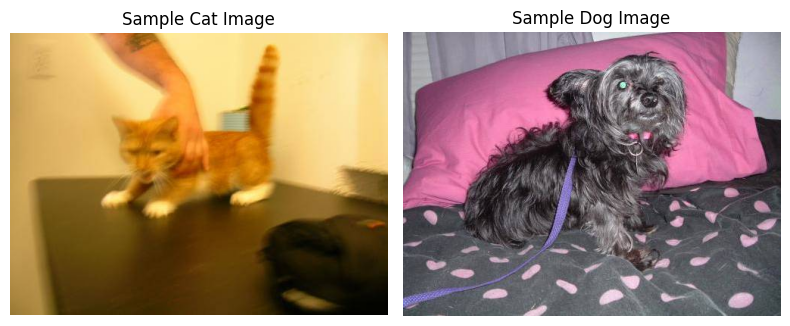

In [20]:
import matplotlib.image as mpimg

cat_sample = list((train_dir / "cats").glob("*.jpg"))[0]
dog_sample = list((train_dir / "dogs").glob("*.jpg"))[0]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(mpimg.imread(cat_sample))
axs[0].set_title("Sample Cat Image")
axs[0].axis('off')

axs[1].imshow(mpimg.imread(dog_sample))
axs[1].set_title("Sample Dog Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()


##  Question 3: Train Two Models

In this section, I trained two models:
1. A simple custom CNN model I made myself (just basic layers)
2. A fine-tuned VGG16 model that uses pre-trained weights from ImageNet

For both models, I used `ModelCheckpoint` to save the best version during training, and I also tracked training vs. validation accuracy to watch for overfitting.


In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define custom CNN
simple_model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

simple_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Callbacks to save best model and stop early if overfitting
callbacks = [
    ModelCheckpoint("simple_cnn_best.h5", save_best_only=True),
    EarlyStopping(patience=3, restore_best_weights=True)
]


In [22]:
history_simple = simple_model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=callbacks
)


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 951ms/step - accuracy: 0.6147 - loss: 0.6439

594/594 ━━━━━━━━━━━━━━━━━━━━ 585s 981ms/step - accuracy: 0.6148 - loss: 0.6438 - val_accuracy: 0.6810 - val_loss: 0.6117
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.7575 - loss: 0.5040

594/594 ━━━━━━━━━━━━━━━━━━━━ 381s 641ms/step - accuracy: 0.7576 - loss: 0.5040 - val_accuracy: 0.7620 - val_loss: 0.4854
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 569ms/step - accuracy: 0.8166 - loss: 0.4067

594/594 ━━━━━━━━━━━━━━━━━━━━ 343s 578ms/step - accuracy: 0.8166 - loss: 0.4067 - val_accuracy: 0.8180 - val_loss: 0.4057
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 335s 564ms/step - accuracy: 0.8487 - loss: 0.3404 - val_accuracy: 0.8240 - val_loss: 0.4139
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 338s 569ms/step - accuracy: 0.8866 - loss: 0.2607 - val_accuracy: 0.8260 - val_loss: 0.4076
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 360s 606ms/step - accuracy: 0.9108 - loss: 0.2120 - val_accuracy: 0.8080 - val_loss: 0.5178


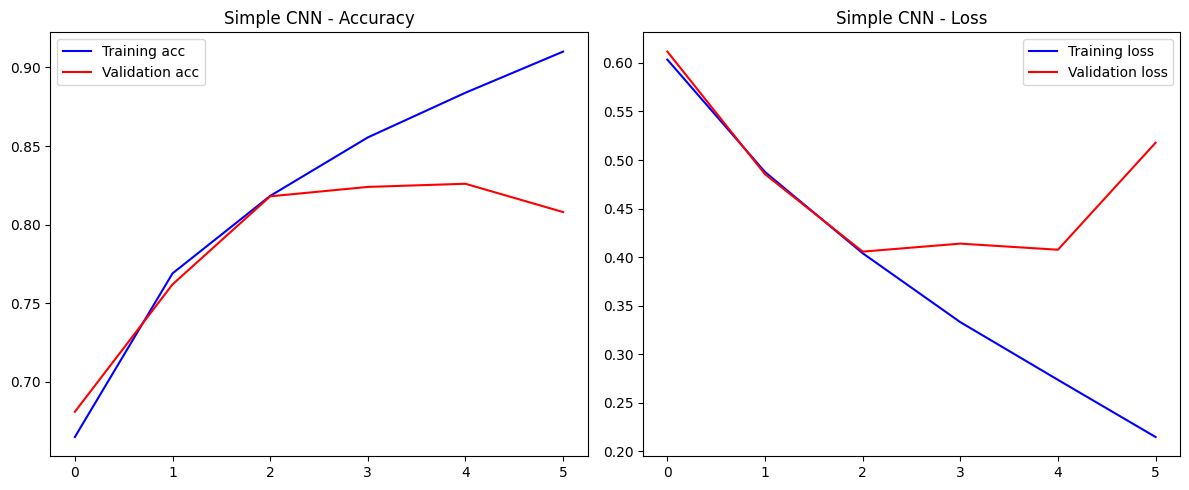

In [23]:
def plot_history(history, title='Model Training'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_simple, title='Simple CNN')


### 3.2 Fine-Tuning a Pretrained VGG16 Model

Here I used the VGG16 model which is already trained on ImageNet. I used its convolutional base and added some custom layers on top.

I made sure to freeze the base model first so it doesn't get updated during training. Also used callbacks again just like in the first model.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

# Set your paths again
train_dir = Path("C:/Users/Dell/Downloads/Lab 03/catsanddogs/dataset/train")
valid_dir = Path("C:/Users/Dell/Downloads/Lab 03/catsanddogs/dataset/valid")

# Rescale images
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 19000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history_vgg = vgg_model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    callbacks=vgg_callbacks
)



c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8160 - loss: 0.4874

594/594 ━━━━━━━━━━━━━━━━━━━━ 1637s 3s/step - accuracy: 0.8161 - loss: 0.4872 - val_accuracy: 0.9020 - val_loss: 0.2396
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9029 - loss: 0.2388

594/594 ━━━━━━━━━━━━━━━━━━━━ 1498s 3s/step - accuracy: 0.9029 - loss: 0.2388 - val_accuracy: 0.9010 - val_loss: 0.2321
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.9061 - loss: 0.2220 

594/594 ━━━━━━━━━━━━━━━━━━━━ 16612s 28s/step - accuracy: 0.9061 - loss: 0.2220 - val_accuracy: 0.9060 - val_loss: 0.2253
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1504s 3s/step - accuracy: 0.9195 - loss: 0.1925 - val_accuracy: 0.9030 - val_loss: 0.2291
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9184 - loss: 0.1937

594/594 ━━━━━━━━━━━━━━━━━━━━ 2801s 5s/step - accuracy: 0.9184 - loss: 0.1937 - val_accuracy: 0.9020 - val_loss: 0.2232
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1492s 3s/step - accuracy: 0.9264 - loss: 0.1726 - val_accuracy: 0.9100 - val_loss: 0.2305
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1853s 3s/step - accuracy: 0.9301 - loss: 0.1671 - val_accuracy: 0.9130 - val_loss: 0.2303
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 1520s 3s/step - accuracy: 0.9355 - loss: 0.1497 - val_accuracy: 0.9140 - val_loss: 0.2315


### Question 4: Explore the Relative Performance of the Models
#### Part 1: Accuracy Comparison

- After training both models (my custom CNN and the fine-tuned VGG16), I compared their final accuracy scores on the validation set. I loaded the best saved versions using `ModelCheckpoint`.


In [13]:
from tensorflow.keras.models import load_model

# Load using the full Windows path (double backslashes or raw string)
cnn_model = load_model(r"C:\Users\Dell\Downloads\Lab 03\simple_cnn_best.h5")
vgg_model = load_model(r"C:\Users\Dell\Downloads\Lab 03\vgg16_best.h5")

print(" Both models loaded successfully!")


 Both models loaded successfully!


In [12]:
# Evaluate both models on the validation set
cnn_acc = cnn_model.evaluate(valid_generator, verbose=0)[1]
vgg_acc = vgg_model.evaluate(valid_generator, verbose=0)[1]

print(f" Custom CNN Validation Accuracy: {cnn_acc:.4f}")
print(f" VGG16 Validation Accuracy: {vgg_acc:.4f}")


 Custom CNN Validation Accuracy: 0.8180
 VGG16 Validation Accuracy: 0.9070


###  part-2 Confusion Matrix

- To understand where each model made mistakes, I generated confusion matrices for both using the validation set. This helps show how many true positives, false positives, etc. there were.


In [15]:
import matplotlib.pyplot as plt


32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


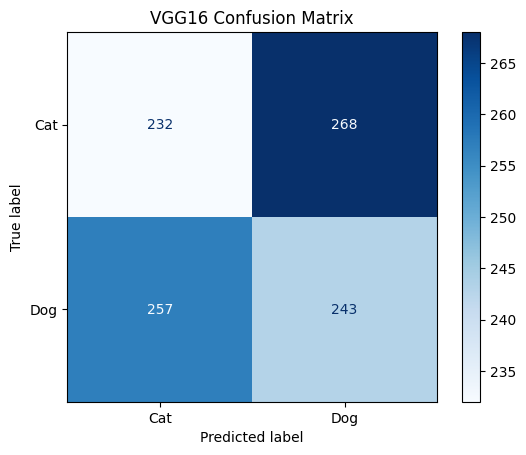

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get true labels and predictions from VGG model
valid_generator.reset()
y_true = valid_generator.classes
y_pred_vgg = (vgg_model.predict(valid_generator) > 0.5).astype("int32")

# Confusion matrix
cm_vgg = confusion_matrix(y_true, y_pred_vgg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_vgg, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.title("VGG16 Confusion Matrix")
plt.show()


###  part.3 Precision, Recall, F1-score

Here I used `classification_report` from sklearn to get precision, recall, and F1-score for the VGG16 model. These metrics are helpful because accuracy alone doesn’t always tell the full story.


In [17]:
from sklearn.metrics import classification_report

print("VGG16 Classification Report:\n")
print(classification_report(y_true, y_pred_vgg, target_names=["Cat", "Dog"]))


VGG16 Classification Report:

              precision    recall  f1-score   support

         Cat       0.47      0.46      0.47       500
         Dog       0.48      0.49      0.48       500

    accuracy                           0.47      1000
   macro avg       0.47      0.47      0.47      1000
weighted avg       0.47      0.47      0.47      1000



###  Part.4 Precision-Recall Curve

I plotted the precision-recall curve to see how the model performs at different thresholds. This is useful when dealing with imbalanced datasets, but I did it here just to see how the trade-off looks.


32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step


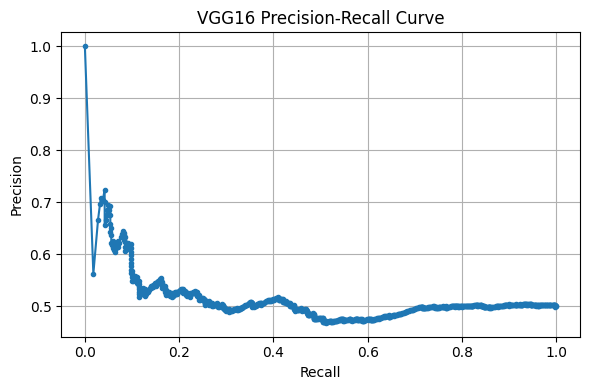

In [18]:
from sklearn.metrics import precision_recall_curve

valid_generator.reset()
y_probs = vgg_model.predict(valid_generator)
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('VGG16 Precision-Recall Curve')
plt.grid(True)
plt.tight_layout()
plt.show()


### part.5 Examples Where the Model Failed

Finally, I looked at a few validation images where the model made wrong predictions. This helps to understand what kind of images are confusing to the model (e.g. blurry, weird angles, etc.).


32/32 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step


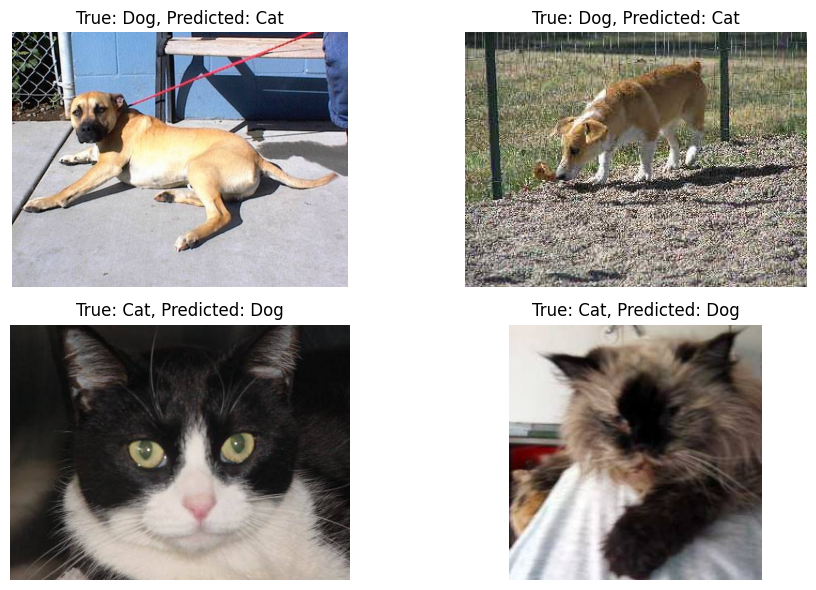

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Regenerate the true and predicted labels
valid_generator.reset()
y_true = valid_generator.classes
y_pred_vgg = (vgg_model.predict(valid_generator) > 0.5).astype("int32")

# Grab file paths of wrong predictions
file_paths = valid_generator.filepaths
wrong_indices = np.where(y_true != y_pred_vgg.flatten())[0]
wrong_samples = random.sample(list(wrong_indices), 4)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(wrong_samples):
    img_path = file_paths[idx]  # full path from generator
    img = mpimg.imread(img_path)
    
    true_label = "Cat" if y_true[idx] == 0 else "Dog"
    pred_label = "Dog" if y_pred_vgg[idx] == 1 else "Cat"
    
    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Predicted: {pred_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


##  Conclusion

- In this lab, I worked on classifying images of cats and dogs using two different models:

1. A custom CNN that I built from scratch
2. A pre-trained VGG16 model fine-tuned for this task

Both models performed decently, but the VGG16 model clearly gave better accuracy and generalization. It also handled complex images better, probably because it already learned good features from training on ImageNet.

I also evaluated both models using accuracy, confusion matrix, precision, recall, F1-score, and the precision-recall curve. Looking at some of the incorrect predictions helped me understand where the model struggles — usually when the image is blurry, zoomed in weird, or just not clear.

Overall, this lab showed how useful transfer learning can be and gave me good hands-on experience with model training, callbacks, and evaluation metrics.
